### アンサンブル学習

3種類のアンサンブル学習をスクラッチ実装していきます。そして、それぞれの効果を小さめのデータセットで確認します。


・ブレンディング

・バギング

・スタッキング

小さなデータセットの用意
以前も利用した回帰のデータセットを用意します。


House Prices: Advanced Regression Techniques


この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使います。


train.csvを学習用（train）8割、検証用（val）2割に分割してください。

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import statistics
from scipy import stats
import collections
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

data = pd.read_csv('train.csv')
y = data["SalePrice"]
X = data[["GrLivArea","YearBuilt"]]
X = X.values
y = y.values


### ブレンディング

ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。


・手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）

・ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）

・入力データの前処理の仕方（例：標準化、対数変換、PCAなど）

重要なのはそれぞれのモデルが大きく異なることです。


回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。

### 【問題1】ブレンディングのスクラッチ実装
ブレンディング をスクラッチ実装し、単一モデルより精度があがる例を 最低3つ 示してください。精度があがるとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを指します。

In [277]:
class Brending():
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state = 1)
        scaler = StandardScaler()
        scaler.fit(self.X_train)
        self.X_train = scaler.transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)
        self.pred_log = []   # 各モデルでの予測結果の記録用
        self.wait_log = []   # 各モデルのMSEの逆数（重み）の記録用
    
    def fit(self, model):
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_test)
        self.pred_log.append(pred)     # 各モデルのMSEの逆数（重み）を記録
        model_num = len(self.pred_log)
        self.wait_log.append(1/mean_squared_error(self.y_test,pred))  # 各モデルのMSEの逆数（重み）を記録
        print("{}個目のモデル学習完了\n{}".format(model_num,model))
        print("-------------------------------------------------")
    
    def predict(self):
        pred = np.zeros(len(self.y_test))
        for i in range(len(self.pred_log)):   # 各モデルでの予測値に重みつけして最終的な予測値に足す。
            pred += self.pred_log[i]*self.wait_log[i]/np.sum(self.wait_log)
        print("MSE:{:.2e}".format(mean_squared_error(self.y_test,pred)))
    
    def all_reflesh(self):
        self.pred_log=[] 
        self.wait_log = []   # 本クラスを初期化する際に使用
        
    def one_reflesh(self):
        self.pred_log = self.pred_log[0:-1] 
        self.wait_log = self.wait_log[0:-1] # 本クラスを1つ前のモデル学習のみ取り消し

#### ●線形回帰のみ

In [258]:
brending = Brending(X,y)
LM = LinearRegression()
brending.fit(LM)

1個目のモデル学習完了
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
-------------------------------------------------


In [235]:
brending.predict()

MSE:1.89e+09


#### ●SVRのみ

In [259]:
brending_svr = Brending(X,y)
svr = SVR(kernel="rbf")
brending_svr.fit(svr)

1個目のモデル学習完了
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
-------------------------------------------------


In [260]:
brending_svr.predict()

MSE:6.84e+09


#### ●決定木のみ

In [261]:
brending_tree = Brending(X,y)
tree_model = DecisionTreeRegressor(max_depth=5)
brending_tree.fit(tree_model)

1個目のモデル学習完了
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
-------------------------------------------------


In [262]:
brending_tree.predict()

MSE:1.73e+09


#### ●線形回帰　＋　SVR

In [285]:
brending_2 = Brending(X,y)
LM = LinearRegression()
svr = SVR(kernel="rbf")
brending_2.fit(LM)
brending_2.fit(svr)

1個目のモデル学習完了
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
-------------------------------------------------
2個目のモデル学習完了
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
-------------------------------------------------


In [286]:
brending_2.predict()

MSE:2.28e+09


####  ●SVR ＋ 決定木

In [249]:
brending_3 = Brending(X,y)
svr = SVR(kernel="rbf")
tree_model = DecisionTreeRegressor(max_depth=5)
brending_3.fit(svr)
brending_3.fit(tree_model)

1個目のモデル学習完了
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
-------------------------------------------------
2個目のモデル学習完了
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
-------------------------------------------------


In [250]:
brending_3.predict()

MSE:1.86e+09


#### ●線形回帰 ＋ 決定木 　（UP）

In [251]:
brending_4 = Brending(X,y)
LM = LinearRegression()
tree_model = DecisionTreeRegressor(max_depth=5)
brending_4.fit(LM)
brending_4.fit(tree_model)

1個目のモデル学習完了
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
-------------------------------------------------
2個目のモデル学習完了
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
-------------------------------------------------


In [253]:
brending_4.predict()

MSE:1.54e+09


#### ●線形回帰 ＋ SVR ＋ 決定木　　（UP）

In [255]:
brending_5 = Brending(X,y)
LM = LinearRegression()
svr = SVR(kernel="rbf")
tree_model = DecisionTreeRegressor(max_depth=5)
brending_5.fit(LM)
brending_5.fit(svr)
brending_5.fit(tree_model)

1個目のモデル学習完了
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
-------------------------------------------------
2個目のモデル学習完了
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
-------------------------------------------------
3個目のモデル学習完了
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
-------------------------------------------------


In [256]:
brending_5.predict()

MSE:1.69e+09


### バギングとは
バギングは入力データの選び方を多様化する方法です。学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ ブートストラップサンプル ）を作り出します。それらによってモデルをN個学習し、推定結果の平均をとります。ブレンディングと異なり、それぞれの重み付けを変えることはありません。


sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation


scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができます。これによりブートストラップサンプルが手に入ります。


推定結果の平均をとる部分はブースティングと同様の実装になります。

### 【問題2】バギングのスクラッチ実装
バギング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。

In [305]:
class Baging():
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state = 5)
        self.pred_log = []  # 予測結果の記録用
    
    def fit(self, model, N):
        for i in range(N):  # N回分 学習データからサンプリングして学習させる
            X_train_boot, _, y_train_boot , _  = train_test_split(self.X_train, self.y_train, shuffle=True)
            model.fit(X_train_boot, y_train_boot)         #モデル学習
            pred = model.predict(self.X_test)             #予測
            self.pred_log.append(pred)                    # 予測結果の記録
        print("{}種類のサブセット（ブートストラップサンプル）学習完了".format(N))
    
    def predict(self):
        pred = np.mean(self.pred_log,axis=0)  # N回分の予測結果の平均を最終的な予測値として算出
        print("MSE:{:.2e}".format(mean_squared_error(self.y_test,pred)))

#### ●決定木のバギング（ランダムフォレスト）

In [306]:
baging_1 = Baging(X, y)
tree_1 = DecisionTreeRegressor(max_depth=5)
baging_1.fit(tree_1,1)   # 1回分(通常)の学習をさせる
baging.predict()

1種類のサブセット（ブートストラップサンプル）学習完了
MSE:3.92e+09


In [307]:
baging_10 = Baging(X, y)
tree_1 = DecisionTreeRegressor(max_depth=5)
baging_10.fit(tree_1,3) # 10回分の学習をさせる
baging_10.predict()

3種類のサブセット（ブートストラップサンプル）学習完了
MSE:1.47e+09


#### ●SVRのバギング

In [308]:
baging_svr = Baging(X, y)
svr = SVR(kernel="rbf")
baging_svr.fit(tree_1,1)  # 1回分(通常)の学習をさせる
baging_svr.predict()

1種類のサブセット（ブートストラップサンプル）学習完了
MSE:1.27e+09


In [312]:
baging_svr_10 = Baging(X, y)
svr = SVR(kernel="rbf")
baging_svr_10.fit(tree_1,10) # 10回分の学習をさせる
baging_svr_10.predict()

10種類のサブセット（ブートストラップサンプル）学習完了
MSE:1.25e+09


#### ●線形回帰のバギング

In [313]:
baging_LM = Baging(X, y)
LM = LinearRegression()
baging_LM.fit(LM,1)   # 1回分(通常)の学習をさせる
baging_LM.predict()

1種類のサブセット（ブートストラップサンプル）学習完了
MSE:1.80e+09


In [314]:
baging_LM_10 = Baging(X, y)
LM = LinearRegression()
baging_LM_10.fit(LM,10)  # 10回分の学習をさせる
baging_LM_10.predict()

10種類のサブセット（ブートストラップサンプル）学習完了
MSE:1.76e+09


### スタッキングとは
スタッキングの手順は以下の通りです。最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装してください。まずは $K_0=3, M_0=2$ 程度にします。


《学習時》


（ステージ $0$ ）


学習データを $K_0$ 個に分割する。
分割した内の $(K_0 - 1)$ 個をまとめて学習用データ、残り $1$ 個を推定用データとする組み合わせが $K_0$ 個作れる。
あるモデルのインスタンスを $K_0$ 個用意し、異なる学習用データを使い学習する。
それぞれの学習済みモデルに対して、使っていない残り $1$ 個の推定用データを入力し、推定値を得る。（これをブレンドデータと呼ぶ）
さらに、異なるモデルのインスタンスも $K_0$ 個用意し、同様のことを行う。モデルが $M_0$ 個あれば、 $M_0$ 個のブレンドデータが得られる。

（ステージ $n$ ）


ステージ $n-1$ のブレンドデータを$M_{n-1}$ 次元の特徴量を持つ学習用データと考え、 $K_n$ 個に分割する。以下同様である。

（ステージ $N$ ）＊最後のステージ


ステージ $N-1$ の $M_{N-1}$ 個のブレンドデータを$M_{N-1}$ 次元の特徴量の入力として、1種類のモデルの学習を行う。これが最終的な推定を行うモデルとなる。

《推定時》


（ステージ $0$ ）


テストデータを $K_0×M_0$ 個の学習済みモデルに入力し、$K_0×M_0$ 個の推定値を得る。これを $K_0$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $n$ ）


ステージ $n-1$ で得たブレンドテストを $K_n×M_n$ 個の学習済みモデルに入力し、$K_n×M_n$ 個の推定値を得る。これを $K_n$ の軸で平均値を求め $M_0$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $N$ ）＊最後のステージ


ステージ $N-1$ で得たブレンドテストを学習済みモデルに入力し、推定値を得る。

### 【問題3】スタッキングのスクラッチ実装
スタッキング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。

In [426]:
class Stacking():
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state = 1)
        self.new_feachers_log = []         # 各レイヤーで予想して次のレーヤーに渡す訓練データを記録
        self.new_test_feacher_log = []     # 各レイヤーで予想して次のレーヤーに渡すテストデータ記録
        self.mse_log = []                  # （参考）各レイヤーでのMSE結果を記録
    
    def fit(self, K_splits, models):
             
        if len(self.new_feachers_log)==0:  #初めのレイヤの場合は初期値の０行列を作成
            self.new_feachers = np.zeros((len(self.X_train),len(models)))
            self.new_test_feacher = np.zeros((len(self.X_test),len(models)))
        
        else:
            self.X_train = self.new_feachers    #2層目以降のレイヤの場合、前のレイヤで予想した訓練及びテストデータを次レイヤの学習用に渡す。
            self.X_test = self.new_test_feacher
            self.new_feachers = np.zeros((len(self.X_train),len(models)))   #2層目以降は、各レイヤに入れるモデル数に応じて再度初期値０行列を作成しておく
            self.new_test_feacher = np.zeros((len(self.X_test),len(models)))     
        
        for i in range(len(models)):
            test_preds = []  #1つのモデルでの各out fold分の学習によるテストデータの予測結果の格納用
            kf = KFold(n_splits=K_splits, random_state=1)                 #引数で指定したKFoldで学習データを分割
            for tr_idx, va_idx in kf.split(self.X_train,self.y_train):
                tr_X, va_X = self.X_train[tr_idx],  self.X_train[va_idx]
                tr_y, va_y = self.y_train[tr_idx],  self.y_train[va_idx]
                model = models[i]
                model.fit(tr_X, tr_y)                   #モデル学習
                pred = model.predict(va_X)
                self.new_feachers[va_idx,i]=pred        #out foldしている学習データを予測
                test_pred = model.predict(self.X_test)  #テストデータを予測
                test_preds.append(test_pred)            #1つのモデルでの各out fold分の学習によるテストデータの予測結果を記録
            pred_mean = np.mean(test_preds,axis=0)      #上記の平均をテストデータの予測値とする
            self.new_test_feacher[:,i] = pred_mean      #1つのレイヤーにおける、各モデルのテストデータの予測値を格納

        self.new_feachers_log.append(self.new_feachers)          #学習データの予測値を記録しておく（後に現在のレイヤ数を確認するために、len関数に入れて確認できる）
        self.new_test_feacher_log.append(self.new_test_feacher)  #テストデータの予測値を記録しておく（後に現在のレイヤ数を確認するために、len関数に入れて確認できる）
        pred = np.mean(self.new_test_feacher,axis=1)             #(参考)学習過程において各レイヤでの予測値を平均値で算出して、MSEを記録しておく。（レイヤごとの評価結果がわかる）
        self.mse_log.append(mean_squared_error(self.y_test,pred))
        
        print("{}layers 学習完了".format(len(self.new_feachers_log)))
        #print("Brend Data:\n{}".format(self.new_feachers))
        #print("Brend Test:\n{}".format(self.new_test_feacher))
            
        
    def predict(self,model):
        model.fit(self.new_feachers,self.y_train)           #レイヤの最後で算出した、訓練データ、テストデータを使い最終的な１モデルでの学習、予測を行う。
        pred = model.predict(self.new_test_feacher)
        self.mse_log.append(mean_squared_error(self.y_test,pred))
        print("{}layers,final MSE result:{:.2e}".format(len(self.mse_log),mean_squared_error(self.y_test,pred)))
        
    def all_reflesh(self):              # （参考）本クラスを初期化する際に使用
        self.new_feachers_log = []
        self.new_test_feacher_log = []   
        self.mse_log = []
        
    def one_reflesh(self):              #　(参考）本クラスを1つ前のモデル学習のみ取り消し
        self.new_feachers_log = self.new_feachers_log[0:-1]
        self.new_test_feacher_log = self.new_feachers_log[0:-1] 
        self.mse_log = self.mse_log[0:-1]   
        
    def plot(self):                    # (参考) 各レイヤでのテストデータ予測値を平均値で算出したもののMSE結果をグラフで確認できる。
        plt.plot(range(1,len(self.mse_log)+1),self.mse_log)
        plt.title("MSE_results")
        plt.xlabel("Layer")
        plt.ylabel("MSE")
        plt.style.use('seaborn-poster')

#### ●1層目　（SVR＋決定木）

In [455]:
stacking = Stacking(X,y)
models = [SVR(kernel="rbf"), DecisionTreeRegressor(max_depth=5)]
stacking.fit(4, models)

1layers 学習完了


/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this

#### ●2層目（SVR＋決定木＋線形回帰）

In [456]:
models_2 = [SVR(kernel="rbf"), DecisionTreeRegressor(max_depth=5),LinearRegression()]
stacking.fit(4, models_2)

2layers 学習完了


/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this

#### ●３層目（決定木）

In [457]:
stacking.predict(DecisionTreeRegressor(max_depth=5))

3layers,final MSE result:2.29e+09


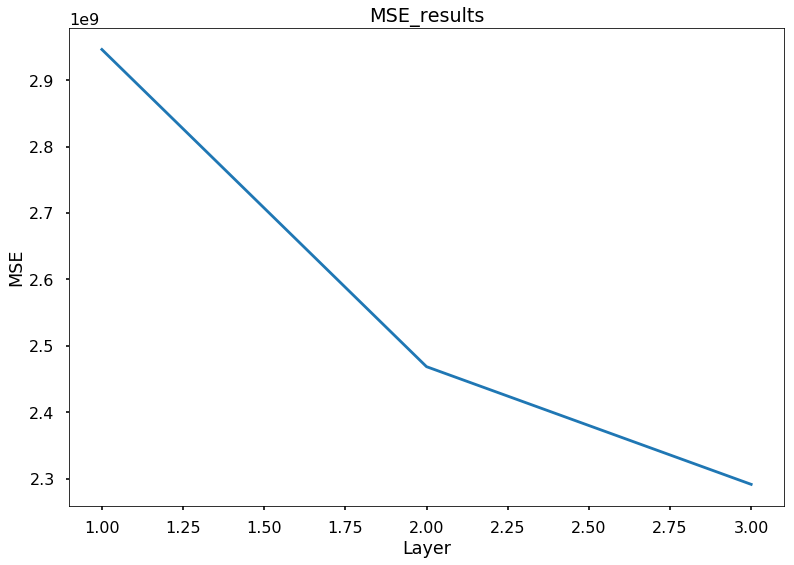

In [458]:
stacking.plot()